In [51]:
from typing import Annotated, TypedDict, Optional, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.utilities import SerpAPIWrapper
from langchain.agents import load_tools, create_tool_calling_agent
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor
import os
import json
import requests

In [52]:
# api key
from dotenv import load_dotenv

load_dotenv()

Python-dotenv could not parse statement starting at line 2
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10
Python-dotenv could not parse statement starting at line 11
Python-dotenv could not parse statement starting at line 12
Python-dotenv could not parse statement starting at line 13
Python-dotenv could not parse statement starting at line 14
Python-dotenv could not parse statement starting at line 15
Python-dotenv could not parse statement starting at line 16
Python-dotenv could not parse statement starting at line 17


True

In [53]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("TEST_LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
TEST_LangGraph


### State 정의 - 두 개의 에이전트 노드 연결 예정

In [54]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    fng: Optional[dict] = None
    # 뉴스 검색 에이전트 노드 추가
    news_search: Optional[dict] = None

### 공포 탐욕 지수 기반 투자 판단 에이전트

In [55]:
# 공포 탐욕 지수 함수 정의
url = "https://api.alternative.me/fng/?date_format=kr&limit="

def get_fng():
    _url = url + "30"
    res = requests.request("GET", _url)
    parsed = json.loads(res.text)
    data = parsed["data"]
    values = [int(item['value']) for item in data]
    return values

In [56]:
# fng_agent 정의
fng_template = """당신은 투자 분석 전문가 입니다. 
    현재 공포 탐욕 지수의 최근 30일 지수의 정보는 다음과 같습니다: {values}

    분석 결과를 다음 JSON 형식으로 제공해주세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "summary": "시장 분석 및 예측 내용을 상세히 서술. 투자 결정을 제안하고 해당 이유를 서술",
    }}

    주의사항:
    - decision은 반드시 BUY 또는 SELL 또는 HOLD 중 하나여야 합니다
    - summary는 현재 시장 상황과 향후 전망을 포함해야 합니다. 투자 결정을 제안하고 해당 이유를 서술해야 합니다
    """
fng_prompt_template = PromptTemplate.from_template(fng_template)

In [57]:
class FngAnalysis(TypedDict):
    summary: str
    decision: Literal["BUY", "SELL", "HOLD"]

In [58]:
llm = ChatOpenAI(model="gpt-4", temperature=0)
json_output_parser = JsonOutputParser(pydantic_object=FngAnalysis)
fng_chain = fng_prompt_template | llm | json_output_parser

In [59]:
def fng_agent(state: State) -> State:
    fng_info = get_fng()
    result = fng_chain.invoke({"values": fng_info})
    return {**state, "fng": {"decision": result["decision"], "summary": result["summary"]}}

### 뉴스 기반 투자 판단 에이전트

In [60]:
# SerpAPIWrapper 초기화(params 조정 가능)
search = SerpAPIWrapper()

In [61]:
# # Tool 등록이 필요할까?
# # tool 로드
# tools = load_tools(["serpapi"])

# # SerpAPI 도구 이름 변경 (필요 시 Search로 이름을 변경하여 프롬프트에 반영)
# search_tool_name = "Search"  # 실제 도구 이름이 'Search'임을 확인했으므로 명확히 사용

In [62]:
# 프롬프트 생성
news_search_template = """당신은 비트코인 시장의 투자 분석 전문가입니다. 
    최신 뉴스에서 비트코인 관련 시장 동향을 조사하고 이를 분석하여 결정하세요.
    
    다음의 뉴스 기사들을 참조하여 BUY, SELL, HOLD 중 하나의 결정을 내리세요:
    {articles}

    결과는 반드시 JSON 형식으로 출력하세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성",
        "summary": "뉴스 동향에 기반한 시장 분석과 투자 결정을 서술",
        "sources": ["뉴스 기사 링크를 포함해 주세요"]
    }}

    주의사항:
    - 반드시 제공된 뉴스 기사를 기반으로 결정하세요.
    - JSON 형식 이외의 응답은 하지 마세요.
    """
news_search_prompt_template = PromptTemplate.from_template(news_search_template)

In [63]:
class NewsSearchAnalysis(TypedDict):
    summary: str
    decision: Literal["BUY", "SELL", "HOLD"]
    sources: list[str]

In [64]:
news_output_parser = JsonOutputParser(pydantic_object=NewsSearchAnalysis)
news_search_chain = news_search_prompt_template | llm | news_output_parser

In [65]:
# 뉴스 검색 에이전트
def news_search_agent(state: State) -> State:
    # SerpAPI 검색을 수행하여 기사 제목과 링크를 추출
    search_results = search.run("bitcoin latest news")  # 검색어를 사용해 뉴스 검색
    articles = "\n".join([f"- {item['title']} ({item['link']})" for item in search_results[:5]])

    # 모델에 기사 제목과 링크 포함해 프롬프트 생성 및 응답 요청
    result = news_search_chain.invoke({"articles": articles})

    return {**state, "news_search": {"decision": result["decision"], "summary": result["summary"], "sources": result["sources"]}}

### 그래프 생성 및 노드 추가

In [66]:
# 노드 추가
graph_builder = StateGraph(State)
graph_builder.add_node("fng_agent", fng_agent)
graph_builder.add_node("news_search_agent", news_search_agent)

In [67]:
# 엣지 추가 (START에서 시작하여 fng_agent -> news_search_agent -> END 순서로 연결)
graph_builder.add_edge(START, "fng_agent")
graph_builder.add_edge("fng_agent", "news_search_agent")
graph_builder.add_edge("news_search_agent", END)

In [68]:
# 그래프 컴파일
graph = graph_builder.compile()

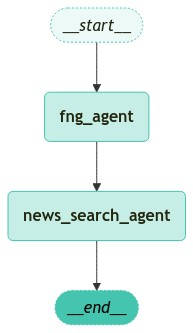

In [69]:
from langchain_teddynote.graphs import visualize_graph
visualize_graph(graph)

### 랭그래프 실행

In [70]:
# 그래프 실행
initial_state = {"messages": [("user", "현재 비트코인 시장에 대해 평가하고, 공포 탐욕 지수와 최근 뉴스 동향을 기반으로 매수(BUY), 매도(SELL), 혹은 보유(HOLD) 중 무엇을 추천하는지 구체적인 분석과 함께 알려주세요."
)]}
result_state = graph.invoke(initial_state)
print(result_state)

{'messages': [HumanMessage(content='현재 비트코인 시장에 대해 평가하고, 공포 탐욕 지수와 최근 뉴스 동향을 기반으로 매수(BUY), 매도(SELL), 혹은 보유(HOLD) 중 무엇을 추천하는지 구체적인 분석과 함께 알려주세요.', additional_kwargs={}, response_metadata={}, id='0ddab225-d8c0-49a6-bd50-87fa35e0aedd')], 'fng': {'decision': 'BUY', 'summary': "공포 탐욕 지수는 투자자들의 시장에 대한 감정 상태를 나타내는 지표입니다. 지수가 50 이상이면 투자자들이 탐욕에 빠져 있음을, 50 미만이면 공포에 빠져 있음을 나타냅니다. 최근 30일 동안의 지수를 보면, 대부분의 기간 동안 지수가 70 이상으로 높게 유지되었으나, 중간에 일시적으로 30대로 떨어진 후 다시 60대로 회복하는 모습을 보였습니다. 이는 시장의 변동성이 높고, 투자자들의 감정이 불안정하다는 것을 의미합니다. 하지만, 최근 지수가 다시 상승세를 보이고 있으므로, 이는 시장의 안정화를 의미할 수 있습니다. 따라서, 현재는 시장에 대한 투자자들의 불안감이 줄어들고, 긍정적인 시장 전망이 예상되므로, 'BUY' 결정을 내립니다."}, 'news_search': {'decision': 'BUY', 'summary': "비트코인 가격이 $70,000를 돌파하며 상승세를 보이고 있습니다. 이는 'Binance Whales'에 의해 주도되는 것으로 보입니다. 또한, 일본의 Metaplanet이 최근 $10 million 투자로 비트코인을 1,000개 이상 보유하게 되었으며, 추가로 $11M를 투자하여 포트폴리오를 강화하였습니다. 이러한 투자 활동은 비트코인에 대한 강력한 신뢰를 보여주며, 시장에 긍정적인 영향을 미칠 것으로 예상됩니다.", 'sources': ['https://www.benzinga.com/markets/cryptocurrency/24/10/41590577/bi